In [5]:
%%capture
# ---------------------------------------------------------------------------- #
#                        DETAILS TECHNIQUES DU NOTEBOOK                        #
# ---------------------------------------------------------------------------- #

%load_ext autoreload
%autoreload 2

import sys
import os

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src', "pytorch")))

# Remove TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Description

Ce notebook a vocation a être lu après avoir lu le notebook présentant notre travail avec la bibliothèque Tensorflow. En effet, si le premier notebook suivait un tutoriel en ligne, celui-ci présente une implémentation libre du papier [Attribution Axiomatique pour les réseaux profonds](https://arxiv.org/abs/1703.01365) dans la bibliothèque **PyTorch**, qui n'est pas la bibliothèque originale de l'article.

Afin de rester cohérent avec notre premier notebook, nous avons décidé de tester la méthode d'Attribution sur le même modèle que dans le premier Notebook : **Inception_V1**.

# Chargement du modèle

In [6]:
from Model import Model

model = Model().summary()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

Using cache found in /home/lopilo24/.cache/torch/hub/pytorch_vision_v0.10.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


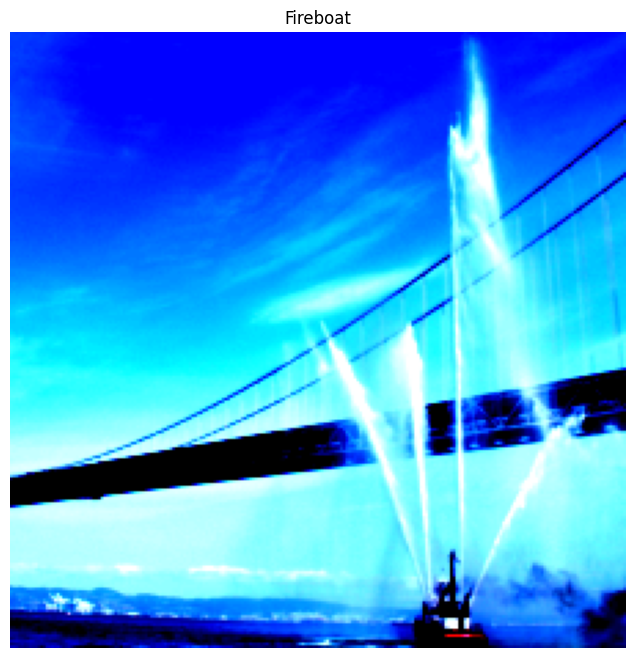

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


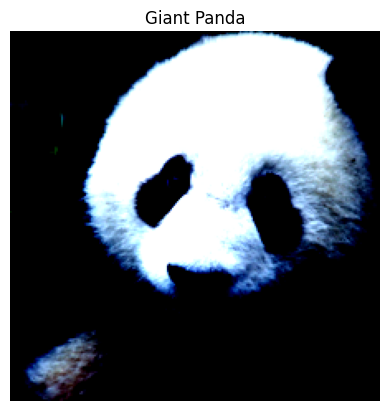

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


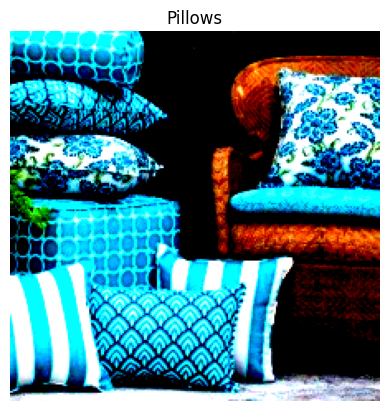

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


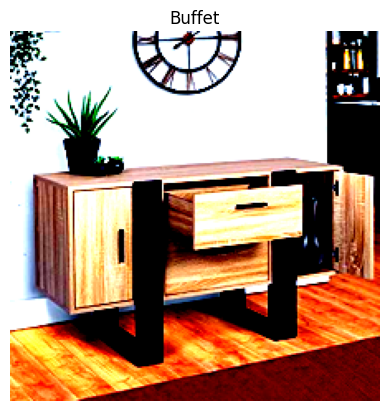

In [7]:
# ---------------------------------------------------------------------------- #
#                             CHARGEMENT DES IMAGES                            #
# ---------------------------------------------------------------------------- #

model = model.load_images({
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
    'Pillows': 'https://www.lecloudore87.fr/bckgd_img/9b4f9edf7f9ef8007419a0a534bce772.jpg',
    'Buffet': 'https://m.media-amazon.com/images/I/51hDVOFQycL._AC_.jpg',
}, display=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


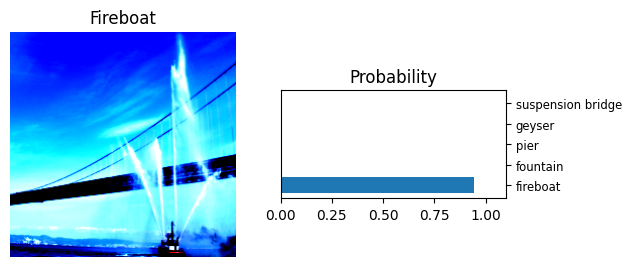

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


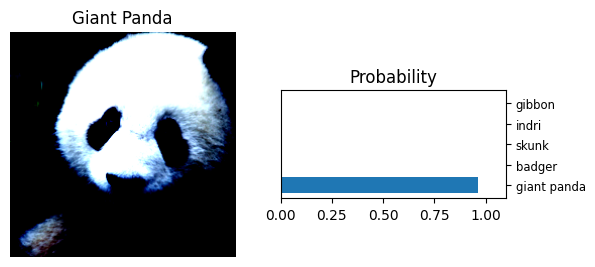

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


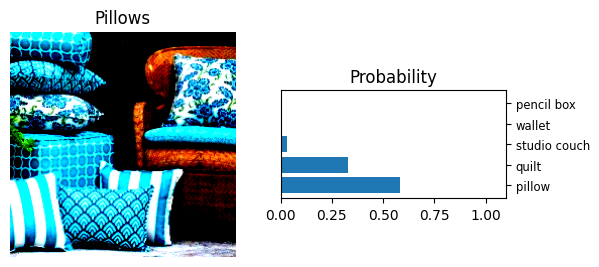

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


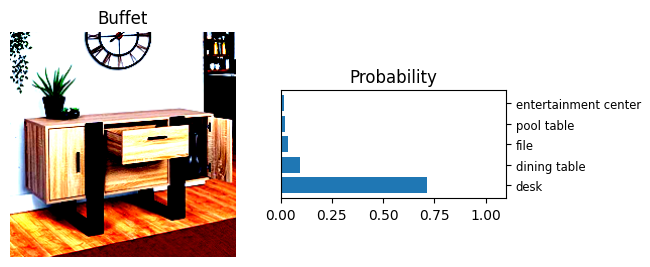

In [8]:
model.predict(display=True)

# Gradients Intégrés

> Contrairement au premier notebook où nous avons privilégié une approche compréhensive, étape par étape de la méthode, nous souhaitons ici implémenter une unique fonction optimisée pour un calcul de nombreuses attributions en parallèle avec une demande en mémoire nettement moindre (car nous ne conservons plus les étapes intermédiaires en mémoire).

Par ailleurs, après avoir lu cet excellentissime [article](https://distill.pub/2020/attribution-baselines/), nous avons décidé d'effectuer notre calcul final à partir d'une moyenne des attributions obtenues par $n$ Baselines aléatoires.

In [9]:
from IntegratedGradients import IntegratedGradients

integrator = IntegratedGradients(model=model, baseline_color="black")
integrator.compute_integrated_gradients(steps=50, number_of_trials=10)

/home/lopilo24/Epita/Ing3/Epita-S9-DNN/src/pytorch/IntegratedGradients.py:215: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_tensor = torch.tensor(


the trial number is: 0
the trial number is: 1
the trial number is: 2
the trial number is: 3
the trial number is: 4
the trial number is: 5
the trial number is: 6
the trial number is: 7
the trial number is: 8
the trial number is: 9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


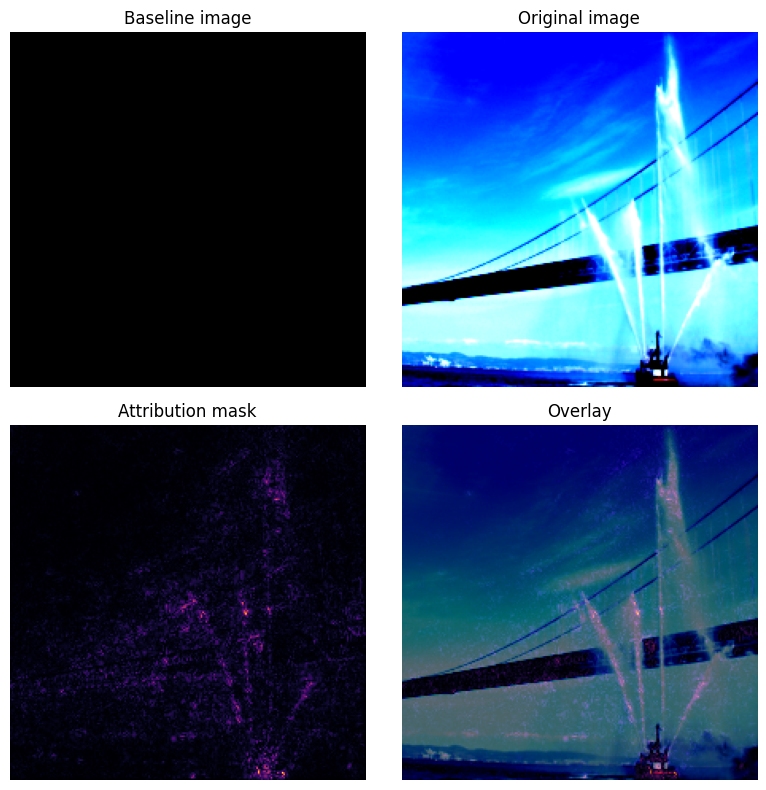

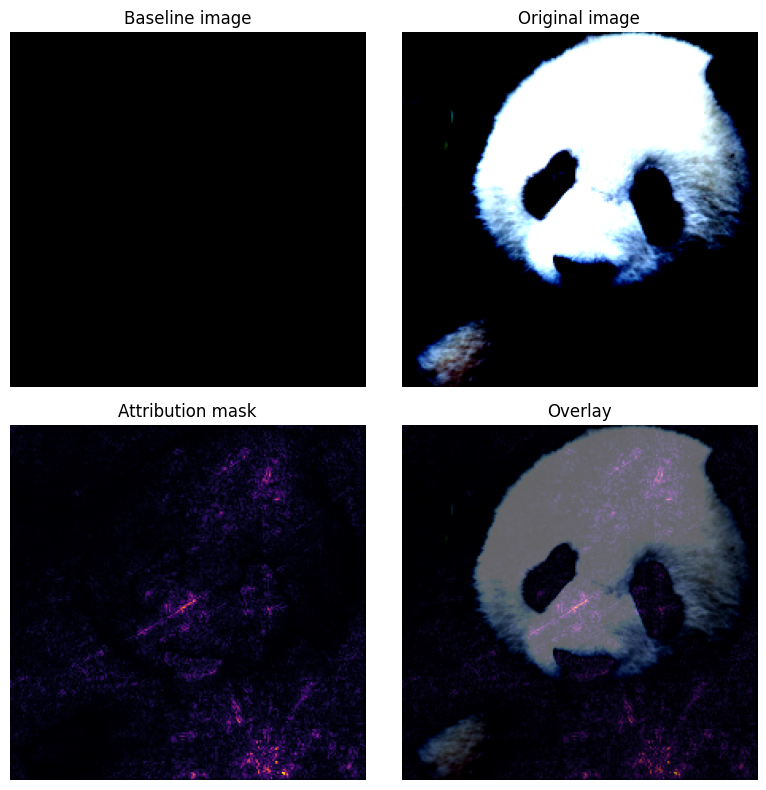

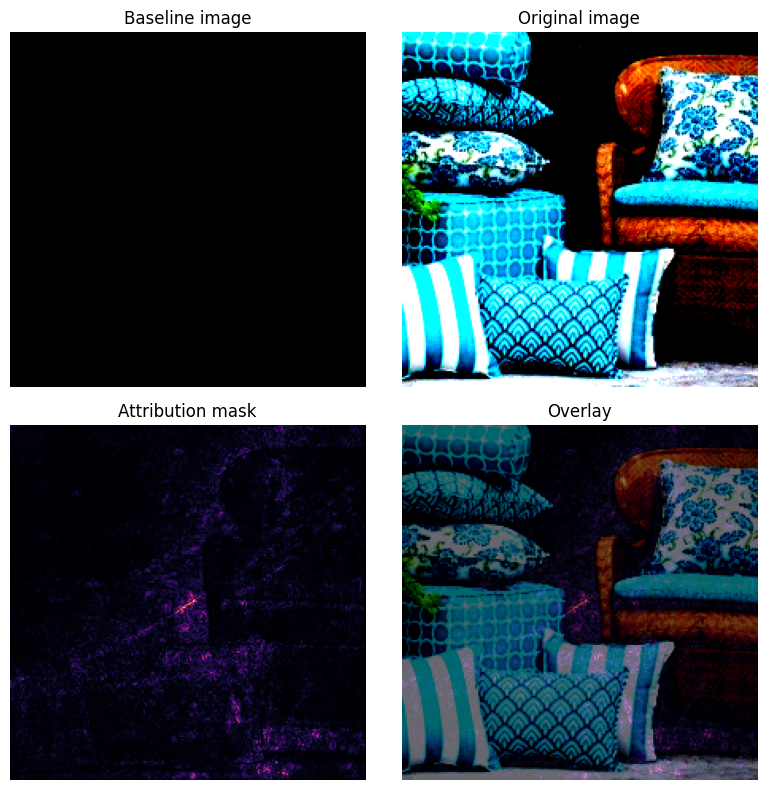

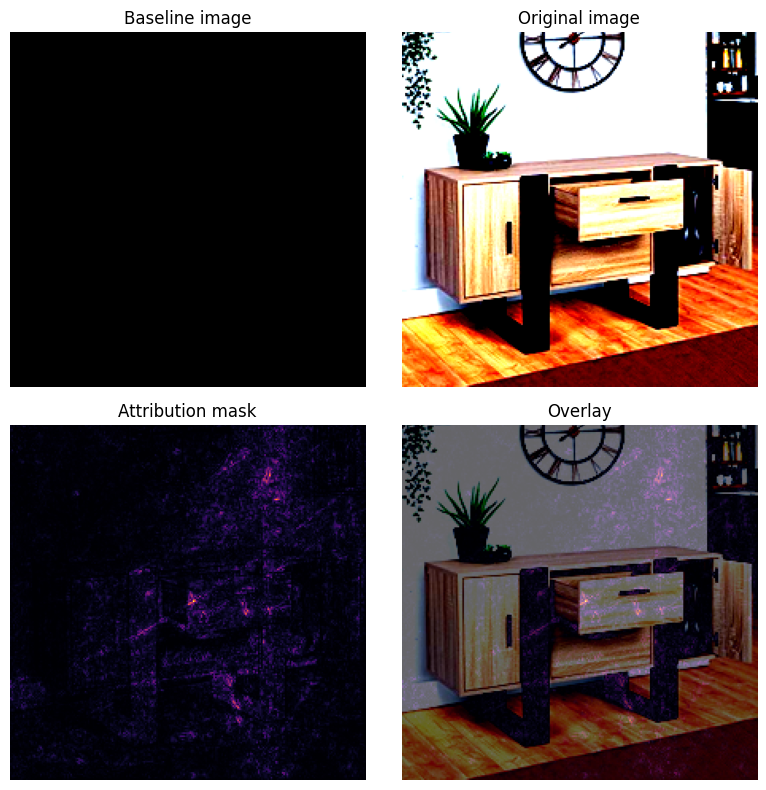

In [10]:
integrator.plot_integrated_gradients(display=['Fireboat', 'Giant Panda', 'Pillows', 'Buffet'])